In [1]:
# do not forget to swapoff -a
import numpy as np       # linear algebra
import pylab as pl       # plots
import tensorflow as tf  # just for data sets (no deep learning yet)

In [2]:
# choose wisely
(train, label_train), (test, label_test) = tf.keras.datasets.mnist.load_data()
(train, label_train), (test, label_test) = tf.keras.datasets.fashion_mnist.load_data()

# make sure your data is floating point
test = test.astype(np.float32)
train = train.astype(np.float32)

# print shapes
print(train.shape, label_train.shape)
print(test.shape, label_test.shape)

((60000, 28, 28), (60000,))
((10000, 28, 28), (10000,))


In [3]:
# here we can subsample in the data set
num_test, num_train = 10000, 30000
test, label_test = test[:num_test], label_test[:num_test]
train, label_train = train[:num_train], label_train[:num_train]

# print shapes
print(train.shape, label_train.shape)
print(test.shape, label_test.shape)

((30000, 28, 28), (30000,))
((10000, 28, 28), (10000,))


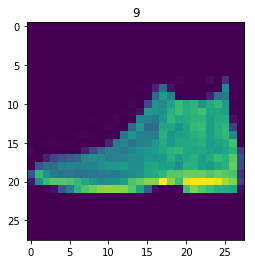

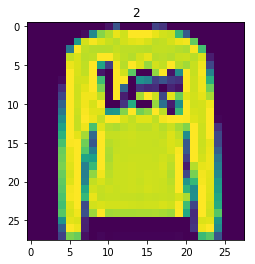

In [4]:
# let us have a look at some examples
num_examples = 2
for label, image in zip(label_test, test)[:num_examples]:
    pl.imshow(image)
    pl.title(str(label))
    pl.show()

In [5]:
import time # time measurement
import tqdm # arabic taquadim "I love you so much!" 

for index in tqdm.tqdm(range(2**5)):
    time.sleep(0.1)
    

100%|██████████| 32/32 [00:03<00:00,  9.83it/s]


In [6]:
# this is really OK but agonizingly slow
"""
begin = time.time()

def predict(image, train, train_label):

    bsf = float("infinity")
    bsf_index = -1

    for index, train_image in enumerate(train):

        # compute distance between image and train_image
        dist = np.sum(np.square(image-train_image), axis=(0, 1))

        if dist < bsf:
            bsf = dist
            bsf_index = index

    return label_train[bsf_index]

label_predicted = np.zeros(label_test.shape)
for index, image in tqdm.tqdm(enumerate(test)):
    label_predicted[index] = predict(image, train, label_train)

print(np.sum(label_test==label_predicted)/float(test.shape[0]),
      time.time()-begin)
"""

'\nbegin = time.time()\n\ndef predict(image, train, train_label):\n\n    bsf = float("infinity")\n    bsf_index = -1\n\n    for index, train_image in enumerate(train):\n\n        # compute distance between image and train_image\n        dist = np.sum(np.square(image-train_image), axis=(0, 1))\n\n        if dist < bsf:\n            bsf = dist\n            bsf_index = index\n\n    return label_train[bsf_index]\n\nlabel_predicted = np.zeros(label_test.shape)\nfor index, image in tqdm.tqdm(enumerate(test)):\n    label_predicted[index] = predict(image, train, label_train)\n\nprint(np.sum(label_test==label_predicted)/float(test.shape[0]),\n      time.time()-begin)\n'

In [7]:
begin = time.time()

# let k enumerate pixels
#  dist(i, j) = sum_k (X_test[i, k]-X_train[j, k])^2
#             = sum_k X_test[i, k]*X_test[i, k]               (A2)
#             - sum_k 2*X_test[i, k]*X_train_[j,k]            (AB)
#             + sum_k X_train[j, k]*X_train[j, k]             (B2)

A2 = np.sum(np.square(test),  axis=(1, 2))
B2 = np.sum(np.square(train), axis=(1, 2))
AB = np.tensordot(test, train, axes=((1, 2), (1, 2)))

A2 = np.expand_dims(A2, 1)
B2 = np.expand_dims(B2, 0)
D = A2-2*AB+B2
print("minimum distance", np.min(D))

best_match = D.argmin(axis=1)
label_predicted = label_train[best_match]

print(np.sum(label_test==label_predicted)/float(test.shape[0]),
      time.time()-begin)

('minimum distance', 433.0)
(0.8327, 5.231136798858643)


In [8]:
# excerpt on broadcasting
X = np.random.normal(0, 1, (10, 3))
S = np.sum(X, axis=1)/X.shape[1]

print(X.shape, S.shape)

# now substract
S = np.expand_dims(S, 1)
X = X-S

print(X.shape, S.shape)
print(np.sum(X, axis=1).round(4))


((10, 3), (10,))
((10, 3), (10, 1))
[ 0.  0. -0.  0.  0.  0.  0. -0.  0.  0.]


In [9]:
###############################################################################
# Task for the audience
###############################################################################

# Let znorm : R^m x R^h x R^w -> R^m x R^h x R^w , X |-> znorm(X)
# such that 

# znorm(X[i, x, y]) = (X[i, x, y] - Mu[i])/Sigma[i]

# where Mu[i] = 1/(w*h) sum_x sum_y X[i, x, y] is the mean over all pixels
# and Sigma[i] = sqrt(1/(w*h) sum_x sum_y (X[i, x, y] - Mu[i])^2)
#
# Remark: Have a look at the functions np.mean and np.std 
# and their parameter axis. Further exploit broadcasting.
# 
# 1. Implement the znorm function, check it for correctness
# 2. Reformulate the 1NN objective, what about the self-interaction terms?
# 3. Compute classification accuracy and measure runtime.

In [10]:
################################################################################
# task for the audience
################################################################################

def znorm(data):

    mean = np.expand_dims(np.expand_dims(np.mean(data, axis=(1, 2)), 1), 2)
    std  = np.expand_dims(np.expand_dims(np.std(data,  axis=(1, 2)), 1), 2)

    return (data-mean)/std

train = znorm(train)
test = znorm(test)

begin = time.time()
AB = np.tensordot(test, train, axes=((1, 2), (1, 2)))
D = 2*784-2*AB
print("minimum distance:", np.min(D))

best_match = D.argmin(axis=1)
label_predicted = label_train[best_match]

print(np.sum(label_test==label_predicted)/float(test.shape[0]),
      time.time()-begin)

('minimum distance:', 0.0715332)
(0.8452, 4.698229789733887)


In [11]:
################################################################################
# make it really fast (this will probably not work on your laptop)
################################################################################

# here we use a GeForce GT 750M with 
#  - 2GB of GDDR5 RAM @ 64.19 GB/s 
#  - 742.7 GFLOPS FP32 performance

# typically you would use a Tesla V100 
#  - 16 GB of HBM2 RAM @ 920 GB/s
#  - 15.7 TFLOPS FP32 performance 

# use the latest version directly from github
# pip install --user git+git://github.com/lebedov/scikit-cuda

import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.linalg as linalg
import skcuda.misc as misc

begin = time.time()

linalg.init()
A_gpu = gpuarray.to_gpu(test.reshape((-1, 784)))
B_gpu = gpuarray.to_gpu(train.reshape((-1, 784)))
AB_gpu = linalg.dot(A_gpu, B_gpu, "N", "T")

best_match = misc.argmax(AB_gpu, axis=1).get()

# delete those GPU arrays directly
del A_gpu
del B_gpu
del AB_gpu

label_predicted = label_train[best_match]

print(np.sum(label_test==label_predicted)/float(test.shape[0]),
      time.time()-begin)

(0.8452, 1.7812631130218506)
